In [1]:
#| label: code
#| output: truecl
#| include: true
#| code-fold: false

## Data manipulation imports
import pandas as pd
import numpy as np

## Display imports
from IPython.display import display, Markdown

## statmodels import
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.genmod.families.family as fam
from patsy import dmatrices

## Plot imports
import matplotlib.style as style
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5,5/2.5)
import seaborn as sns
sns.set_style('whitegrid')
sns.set_theme()
sns.set_context(
    "paper", 
    rc={
        "figsize"       :   plt.rcParams['figure.figsize'],
        'font_scale'    :   1.25,
    }
)
style.use("ggplot")
height = plt.rcParams['figure.figsize'][0]
aspect = plt.rcParams['figure.figsize'][0] / plt.rcParams['figure.figsize'][1] / 2

# Motivation
Did you ever dream to build your own fast API? Well, as the title of this post suggests, [FastAPI](https://fastapi.tiangolo.com/) is really fast and easy to use, even the documentation is very well written. FastAPI is a modern, high-performance web framework for building APIs with Python. It blends the ease of use of Python with exceptional speed, making it an ideal choice for developing robust and efficient web applications. Leveraging asynchronous programming, FastAPI offers lightning-fast execution, enabling real-time applications and high-traffic services. Its automatic validation, interactive documentation, and type hints enhance developer productivity and code reliability. Whether you're crafting a simple REST API or a complex microservices architecture, FastAPI streamlines development, promotes clean code, and optimizes performance, making it the go-to framework for those seeking both speed and simplicity in their Python web projects.

# Data
I have alway being facinated how the Switzerland works when it come to taxation individuals and companies. Switzerland's unique tax system is characterized by its federal structure, granting significant fiscal autonomy to its municipalities and cantons. The country's taxation policies are designed to maintain a balanced distribution of responsibilities and resources between the federal government, cantonal governments, and local municipalities. This results in a decentralized tax framework where both cantons and municipalities possess substantial authority over taxation, allowing them to tailor policies according to their specific needs and preferences. This system encourages competition among cantons and municipalities while also fostering a sense of local ownership and control over financial matters. As a result, Switzerland's tax landscape is complex, diverse, and reflective of the nation's commitment to decentralized governance.

We are going to work in this post with data from the nicest and best canton of Switzerland called Zurich :)

In [2]:
#| output: true
#| include: true
#| code-fold: false

try:
    # helper function for reading datasets with proper separator
    def get_dataset(url):
        if url[-3:] != "csv":
            print(
                """"
                The data set URL has no proper 'csv' extension. Reading the dataset might not have worked as expected.
                Please check the dataset link and adjust pandas' read_csv() parameters accordingly.
                """
            )
        data = pd.read_csv(
            url, 
            sep = ",", 
            on_bad_lines = 'warn', 
            encoding_errors = 'ignore', 
            low_memory = False,
        )
        # if dataframe only has one column or less the data is not comma separated, use ";" instead
        if data.shape[1] <= 1:
            data = pd.read_csv(
                url, 
                sep=';', 
                on_bad_lines='warn', 
                encoding_errors='ignore', 
                low_memory=False,
            )
            if data.shape[1] <= 1:
                print("The data wasn't imported properly. Very likely the correct separator couldn't be found.\nPlease check the dataset manually and adjust the code.")
        return data

    df = (
        get_dataset(
            'https://www.web.statistik.zh.ch/ogd/data/KANTON_ZUERICH_286.csv'
        )
        [['GEBIET_NAME', 'INDIKATOR_JAHR', 'INDIKATOR_VALUE']]
        .rename(
            columns = {
                'GEBIET_NAME'       :   'Municipality',
                'INDIKATOR_JAHR'    :   'Year',
                'INDIKATOR_VALUE'   :   'IncomeTax',
            }
        )
    )

    df.to_parquet(
        '../../data/IncomeTax.parquet',
    )
except:
    df.read_parquet(
        '../../data/IncomeTax.parquet',
    )

In [3]:
#| echo: false

display(
    Markdown(
        f"We have data from {df.Municipality.nunique()} municipalities during the period between {df.Year.min()}-{df.Year.max()}. " + " "
        f"The data presents the mean income tax per municipality and year."
    )
)

We have data from 201 municipalities during the period between 1990-2022.  The data presents the mean income tax per municipality and year.

/Users/Bernardo/opt/anaconda3/envs/master/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 500x200 with 0 Axes>

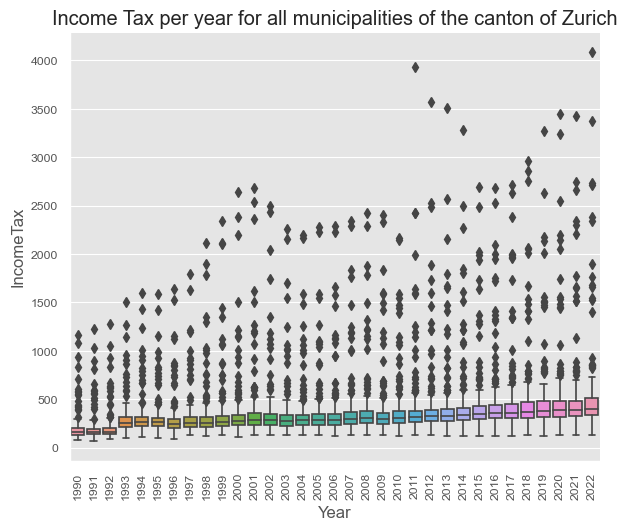

In [9]:
plt.figure()
g = sns.catplot(
    data = df,
    x = 'Year',
    y = 'IncomeTax',
    height = height,
    aspect = aspect,
    kind='box',
)
plt.xticks(rotation=90)
plt.title('Income Tax per year for all municipalities of the canton of Zurich')
plt.show()

# Requirements
For this post we use `python>=3.7` and `fastapi==0.101.1`.


# Installation
You will need to install two packages: (1) FastAPI and (2) Uvicorn. The first one is the framework itself and the second one is the server that will run the API. 

```bash
pip install fastapi
pip install uvicorn[standard]
```

# Introduction

In [5]:
import statsmodels.api as sm
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String

# Create a connection to the database
engine = create_engine(
    'sqlite:///../data/FastAPI.db', echo=True
)

iris = (
    sm
    .datasets
    .get_rdataset('iris')
    .data
)

In [6]:
from typing import Union
from fastapi import FastAPI

app = FastAPI()

@app.get("/")
def read_root():
    return {"Hello": "World"}

@app.get("/items/{item_id}")
def read_item(
    item_id: int, 
    q: Union[str, None] = None,
):
    return {"item_id": item_id, "q": q}